# This is for waltzdb

In [1]:
import mlflow
import matplotlib.pyplot as plt
from mlflow import MlflowClient
from mlflow.entities import ViewType
import pandas as pd
import pprint
import json
import ast
import sys
sys.path.insert(0, '/novo/projects/departments/cdd/public/users/ehec/au24/ML-BP-Domino')

from omegaconf import OmegaConf
import seaborn as sns
import lacroix
from sklearn.decomposition import PCA

from pathlib import Path
from hydra import compose, initialize, initialize_config_dir
from src.helpers.dataset import CSVDataLoader
from src.model.composite_model import CompositeModel
from torch.nn.utils.rnn import pad_sequence
import matplotlib.gridspec as gridspec

import torch
from sklearn.metrics import matthews_corrcoef
from src.helpers.pytorch.light_attention import LightAttentionModule
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
import os

2025-06-08 17:49:02.073373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-08 17:49:02.076688: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-08 17:49:02.396847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-08 17:49:02.992869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-08 17:49:15.588047: W tensorflow/compiler/tf2

In [44]:
serrano = pd.read_csv('/novo/projects/departments/cdd/public/users/ehec/sbxw_files_2/fibrillatioNN_prediction/sbxw/tables/serrano_filteredlysozyme_filteredwaltzoverlap_filteredlt6.csv')
waltz = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10.csv')
waltz_plain = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb.csv').sample(n=150)
amypro = pd.read_csv('/novo/projects/departments/cdd/public/users/ehec/au24/datasets/amypro22.csv')
waltzneg = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_waltznegativeaapadded10x_padlen-10.csv')
waltztruerand = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_TRUErandpadded10x_padlen-10.csv')
waltz5 =pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-5.csv')
waltz20 = pd.read_csv('/novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-20.csv')

waltz5 = waltz5[waltz5['fold'] != -1]
waltz20 = waltz20[waltz20['fold'] != -1]
waltzneg = waltzneg[waltzneg['fold'] != -1]
waltztruerand = waltztruerand[waltztruerand['fold'] != -1]
waltz = waltz[waltz['fold'] != -1]
waltz_padded = waltz.replace('train', 'test').sample(n=150)
waltz_padded['data_split_fold1'] = 'test'
waltz_padded['data_split_fold2'] = 'test'
waltz_padded['data_split_fold3'] = 'test'
waltz_padded['data_split_fold4'] = 'test'
waltz_padded['data_split_fold5'] = 'test'
serrano['data_split_fold1'] = 'test'
serrano['data_split_fold2'] = 'test'
serrano['data_split_fold3'] = 'test'
serrano['data_split_fold4'] = 'test'
serrano['data_split_fold5'] = 'test'
waltz_plain['data_split_fold1'] = 'test'
waltz_plain['data_split_fold2'] = 'test'
waltz_plain['data_split_fold3'] = 'test'
waltz_plain['data_split_fold4'] = 'test'
waltz_plain['data_split_fold5'] = 'test'
amypro['data_split_fold1'] = 'test'
amypro['data_split_fold2'] = 'test'
amypro['data_split_fold3'] = 'test'
amypro['data_split_fold4'] = 'test'
amypro['data_split_fold5'] = 'test'
for i in range(5):
    waltzneg[f'data_split_fold{i+1}'] = 'test'
    waltztruerand[f'data_split_fold{i+1}'] = 'test'
    waltz5[f'data_split_fold{i+1}'] = 'test'
    waltz20[f'data_split_fold{i+1}'] = 'test'
waltz5 = waltz5.sample(n=150, random_state=42)
waltz20 = waltz20.sample(n=150, random_state=42)
waltz_padded = waltz_padded.sample(n=150, random_state=42)
waltzneg = waltzneg.sample(n=150, random_state=42)
waltztruerand = waltztruerand.sample(n=150, random_state=42)

/tmp/ipykernel_240608/92654364.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  waltz_padded = waltz.replace('train', 'test').sample(n=150)


In [45]:
#folders = ['plain_waltz_pad_best_model_1', 'plain_waltz_pad_best_model_2', 
#           'plain_waltz_pad_best_model_3', 'plain_waltz_pad_best_model_4', 'plain_waltz_pad_best_model_5']
folders = ['plain_waltz_pad_best_model_4']

In [46]:
ldf = {}
ldf_serr = {}
ldf_wp = {}
ldf_ap = {}
ldf_wneg = {}
ldf_wrand = {}
ldf_w5 = {}
ldf_w20 = {}
for idx, folder in enumerate(folders):
    amypro_tmp = amypro[amypro[f'data_split_fold{idx+1}'] == 'test']
    serrano_tmp = serrano[serrano[f'data_split_fold{idx+1}'] == 'test']
    waltz_plain_tmp = waltz_plain[waltz_plain[f'data_split_fold{idx+1}'] == 'test']
    waltz_tmp = waltz_padded[waltz_padded[f'data_split_fold{idx+1}'] == 'test']
    labels = np.concatenate([len(row['sequence']) * [row['value_bool']] for index, row in waltz_tmp.iterrows()]).tolist()
    pad_mask = [x for xs in list(waltz_tmp['mask']) for x in xs]
    config_path = f'/novo/projects/departments/cdd/public/users/ehec/au24/250317_models/{folder}'
    
    with initialize_config_dir(config_dir=config_path, version_base=None, job_name="test"):
        cfg = compose(config_name="esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10",
                      overrides=[f"+general.composite_model_path={config_path}"])
        print(OmegaConf.to_yaml(cfg))
        model = CompositeModel(cfg)

    dataloader = CSVDataLoader(cfg, waltz_tmp)
    predictions = model.forward(dataloader)
    ldf[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_serr = CSVDataLoader(cfg, serrano_tmp)
    predictions_serr = model.forward(dataloader_serr)
    ldf_serr[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_wp = CSVDataLoader(cfg, waltz_plain_tmp)
    predictions_wp = model.forward(dataloader_wp)
    ldf_wp[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_ap = CSVDataLoader(cfg, amypro_tmp)
    predictions_ap = model.forward(dataloader_ap)
    ldf_ap[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_wneg = CSVDataLoader(cfg, waltzneg)
    predictions_wneg = model.forward(dataloader_wneg)
    ldf_wneg[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_wrand = CSVDataLoader(cfg, waltztruerand)
    predictions_wrand = model.forward(dataloader_wrand)
    ldf_wrand[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_5 = CSVDataLoader(cfg, waltz5)
    predictions_5 = model.forward(dataloader_5)
    ldf_w5[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]

    dataloader_20 = CSVDataLoader(cfg, waltz20)
    predictions_w20 = model.forward(dataloader_20)
    ldf_w20[f'embeddings_{idx+1}'] = [i for i in np.mean(np.array(model.predictor.model.plm_embeddings.cpu()), axis=2)]
    
ldf = pd.DataFrame(ldf) # 600
ldf_serr = pd.DataFrame(ldf_serr)
ldf_wp = pd.DataFrame(ldf_wp) # 300
ldf_ap = pd.DataFrame(ldf_ap)
ldf_wrand = pd.DataFrame(ldf_wrand)
ldf_wneg = pd.DataFrame(ldf_wneg)
ldf_w20 = pd.DataFrame(ldf_w20)
ldf_w5 = pd.DataFrame(ldf_w5)
print(len(ldf), len(ldf_serr), len(ldf_wp), len(ldf_ap))

INFO:src.model.dimred:Load class (NoReduction): NoReduction
INFO:src.model.abstract_components:Load class (DimRed Model): NoReduction
INFO:src.model.predictors:Load class (LightAttention): LightAttention
INFO:src.model.abstract_components:Load class (TorchPredictorModel): LightAttention
INFO:src.model.abstract_components:Load class (Predictor Model): LightAttention
INFO:src.model.predictors:Loading model from /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/plain_waltz_pad_best_model_4/model.pt


general:
  run_mode: test
  abs_repo_path: null
  composite_model_name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10
  composite_model_path: /novo/projects/departments/cdd/public/users/ehec/au24/250317_models/plain_waltz_pad_best_model_4
  precomputed_embeddings_path: null
  random_state: 42
dataset:
  data_name: sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10
  add_data_columns: []
  data_columns_dimred: []
  data_columns_standard: []
  group_column: null
  data_scaler: RobustScaler
  target_scaling: null
  rbf_encoder: RadialBasisFunctionGaussian
  rbf_n_kernels: 10
  task: classification_binary
  use_predefined_split: true
  use_sample_weights: false
  residue_prediction_labels: null
  data_split_column: data_split_fold4
  data_split:
    train: 0.8
    val: 0.0
    test: 0.2
embedder:
  class_name: ESM
  model_name: esm2_t6_8M_UR50D
  model_path: null
  standardize: false
  scalar

INFO:src.model.composite_model:Composite model name: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10
INFO:src.model.composite_model:Initialized model: esm2t68MUR50D_LightAttention_sbxwfibrillationpeptidewaltzdb-5foldtrain-valserrano-testrandpadded10xpadlen-10 in run_mode = test
INFO:src.helpers.dataset:Loading file: /novo/projects/departments/cdd/molecular_ai/mlbp/data/fibrillation_data/sbxw_fibrillation_peptide_waltzdb-5fold_train-val_serrano-test_randpadded10x_padlen-10.csv
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 11190), validation (N = 2800), test (N = 158)
INFO:src.helpers.dataset:Loaded columns: {}
INFO:src.helpers.dataset:Using group_column "None".
INFO:src.helpers.dataset:Select data according to predetermined splits in the dataframe, train (N = 0), validation (N = 0), test (N = 150)
INFO:src.helpers.dataset:

150 158 150 22


In [47]:
#ldf['predictions_average'] = ldf[['predictions_1', 'predictions_2', 'predictions_3', 'predictions_4', 'predictions_5']].mean(axis=1)
#ldf['Aggregation label'] = ldf['res_value_bool'].astype(bool)

In [66]:
tsne = TSNE(n_components=2,perplexity=10,init='pca',random_state=42)
X_new_all = tsne.fit_transform(np.array(list(ldf_ap['embeddings_1'])+list(ldf['embeddings_1'])
                                    +list(ldf_serr['embeddings_1'])+list(ldf_wp['embeddings_1'])
                                    +list(ldf_wneg['embeddings_1'])+list(ldf_wrand['embeddings_1'])
                                    +list(ldf_w5['embeddings_1'])+list(ldf_w20['embeddings_1']))) # pass in the [N,H] embedding vector
#X_new = tsne.fit_transform(np.array(list(ldf_ap['embeddings_1'])+list(ldf['embeddings_1'])
#                                    +list(ldf_serr['embeddings_1'])+list(ldf_wp['embeddings_1']))) # pass in the [N,H] embedding vector

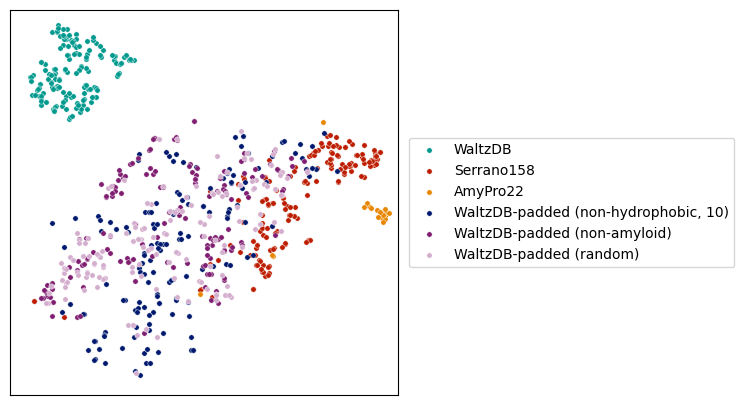

In [74]:
fig = plt.figure(figsize=(5,5))
#plt.title('perp=30')
sns.scatterplot(x=X_new_all[-750:-600,0], y=X_new_all[-750:-600,1], s=15, label='WaltzDB', c=lacroix.colorList('Apricot')[3])
sns.scatterplot(x=X_new_all[172:-750,0], y=X_new_all[172:-750,1], s=15, label='Serrano158', c=lacroix.colorList('Apricot')[0])
sns.scatterplot(x=X_new_all[:22,0], y=X_new_all[:22,1], s=15, label='AmyPro22', c=lacroix.colorList('Apricot')[1])

sns.scatterplot(x=X_new_all[22:172,0], y=X_new_all[22:172,1], s=15, label='WaltzDB-padded (non-hydrophobic, 10)', c=lacroix.colorList('Apricot')[2])
sns.scatterplot(x=X_new_all[-600:-450,0], y=X_new_all[-600:-450,1], s=15, label='WaltzDB-padded (non-amyloid)', c=lacroix.colorList('Berry')[2])
sns.scatterplot(x=X_new_all[-450:-300,0], y=X_new_all[-450:-300,1], s=15, label='WaltzDB-padded (random)', c=lacroix.colorList('Berry')[0])

#sns.scatterplot(x=X_new_all[-300:-150,0], y=X_new_all[-300:-150,1], s=15, label='WaltzDB-padded (non-hydrophobic, 5)', c=lacroix.colorList('Berry')[4])

#sns.scatterplot(x=X_new_all[-150:,0], y=X_new_all[-150:,1], s=15, label='WaltzDB-padded (non-hydrophobic, 20)', c=lacroix.colorList('CranRaspberry')[1])

plt.legend(fontsize=10, loc='center', bbox_to_anchor=(0, 0, 2.9, 1))
plt.yticks([])
plt.ylim([-60,65])

plt.xticks([])
plt.xlim([-64,85])

plt.show()
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne1_1.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne1_1.pdf', dpi=600, bbox_inches='tight')

#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')

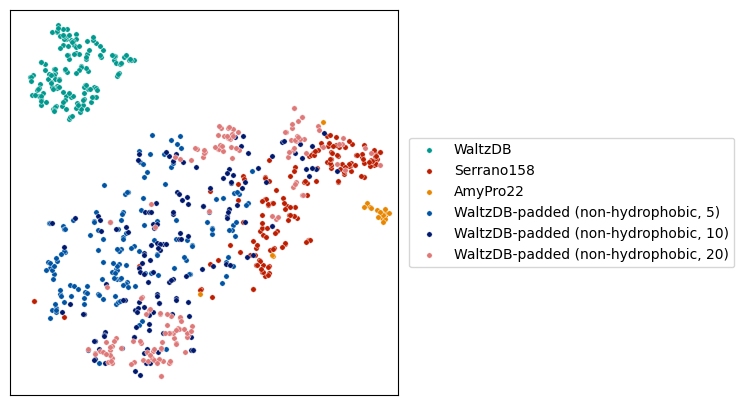

In [76]:
fig = plt.figure(figsize=(5,5))
#plt.title('perp=30')
sns.scatterplot(x=X_new_all[-750:-600,0], y=X_new_all[-750:-600,1], s=15, label='WaltzDB', c=lacroix.colorList('Apricot')[3])
sns.scatterplot(x=X_new_all[172:-750,0], y=X_new_all[172:-750,1], s=15, label='Serrano158', c=lacroix.colorList('Apricot')[0])
sns.scatterplot(x=X_new_all[:22,0], y=X_new_all[:22,1], s=15, label='AmyPro22', c=lacroix.colorList('Apricot')[1])

#sns.scatterplot(x=X_new_all[-600:-450,0], y=X_new_all[-600:-450,1], s=15, label='WaltzDB-padded (non-amyloid)', c=lacroix.colorList('Berry')[2])
#sns.scatterplot(x=X_new_all[-450:-300,0], y=X_new_all[-450:-300,1], s=15, label='WaltzDB-padded (random)', c=lacroix.colorList('Berry')[0])

sns.scatterplot(x=X_new_all[-300:-150,0], y=X_new_all[-300:-150,1], s=15, label='WaltzDB-padded (non-hydrophobic, 5)', c=lacroix.colorList('Berry')[4])
sns.scatterplot(x=X_new_all[22:172,0], y=X_new_all[22:172,1], s=15, label='WaltzDB-padded (non-hydrophobic, 10)', c=lacroix.colorList('Apricot')[2])

sns.scatterplot(x=X_new_all[-150:,0], y=X_new_all[-150:,1], s=15, label='WaltzDB-padded (non-hydrophobic, 20)', c=lacroix.colorList('CranRaspberry')[1])

plt.legend(fontsize=10, loc='center', bbox_to_anchor=(0, 0, 2.9, 1))
plt.yticks([])
plt.ylim([-60,65])

plt.xticks([])
plt.xlim([-64,85])

plt.show()
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne1_2.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne1_2.pdf', dpi=600, bbox_inches='tight')

#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')

In [11]:
lens = list(amypro['len']) + list(waltz_padded['sequence'].apply(lambda x: len(x))) + list(serrano['sequence'].apply(lambda x: len(x))) + list(waltz_plain['sequence'].apply(lambda x: len(x)))
labels = list(amypro['value_bool']) + list(waltz_padded['value_bool']) + list(serrano['value_bool']) + list(waltz_plain['value_bool'])+ list(waltzneg['value_bool']) + list(waltztruerand['value_bool']) + list(waltz5['value_bool']) + list(waltz20['value_bool'])
labels_txt = list(map(lambda x: 'Amyloid' if x == 1 else 'Non-amyloid', labels))


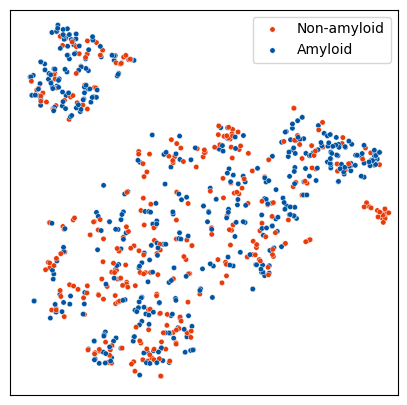

In [78]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=X_new_all[-300:,0], y=X_new_all[-300:,1], s=15, hue=labels_txt[-300:], palette=[lacroix.colorList('PeachPear')[0],lacroix.colorList('Lime')[4]])
sns.scatterplot(x=X_new_all[:-600,0], y=X_new_all[:-600,1], s=15, hue=labels_txt[:-600], palette=[lacroix.colorList('PeachPear')[0],lacroix.colorList('Lime')[4]], legend=None)

plt.legend(fontsize=10, loc='upper right')
plt.yticks([])
plt.ylim([-60,65])

plt.xticks([])
plt.xlim([-64,85])

plt.show()
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne2_2.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne2_2.pdf', dpi=600, bbox_inches='tight')
#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')

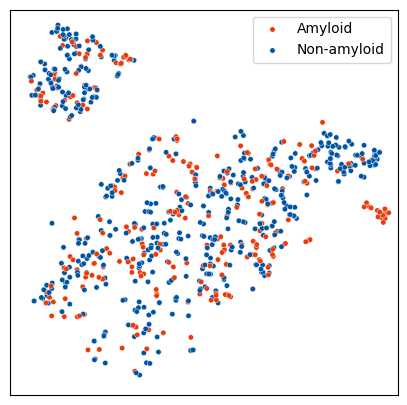

In [79]:
fig = plt.figure(figsize=(5,5))
sns.scatterplot(x=X_new_all[:-300,0], y=X_new_all[:-300,1], s=15, hue=labels_txt[:-300], palette=[lacroix.colorList('PeachPear')[0],lacroix.colorList('Lime')[4]])
plt.legend(fontsize=10, loc='upper right')
plt.yticks([])
plt.ylim([-60,65])

plt.xticks([])
plt.xlim([-64,85])

plt.show()
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne2_1.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_tsne2_1.pdf', dpi=600, bbox_inches='tight')
#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')

In [14]:
pca = PCA(n_components=2)
pca.fit(np.array(list(ldf_ap['embeddings_1'])+list(ldf['embeddings_1'])+list(ldf_serr['embeddings_1'])+list(ldf_wp['embeddings_1'])))
projected_mean_embeddings = pca.transform(np.array(list(ldf_ap['embeddings_1'])+list(ldf['embeddings_1'])+list(ldf_serr['embeddings_1'])+list(ldf_wp['embeddings_1'])))

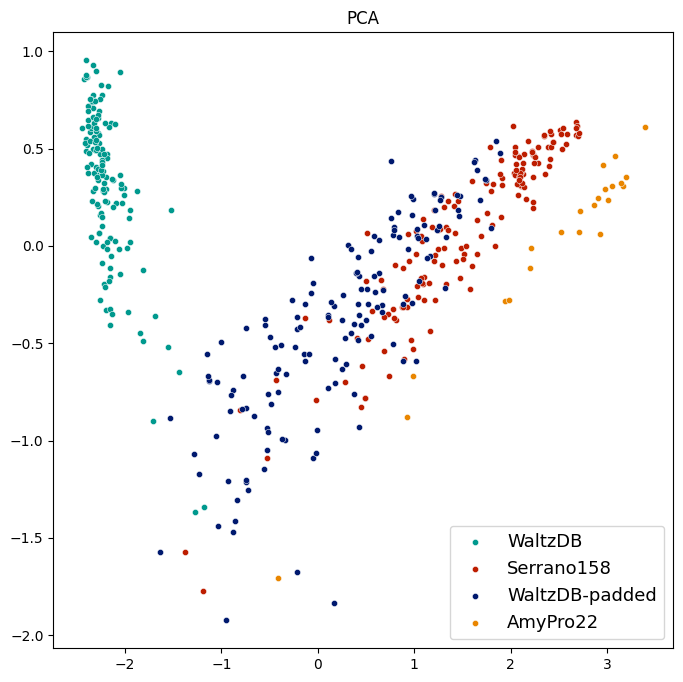

In [15]:
fig = plt.figure(figsize=(8,8))
plt.title('PCA')
sns.scatterplot(x=projected_mean_embeddings[-150:,0], y=projected_mean_embeddings[-150:,1], s=20, label='WaltzDB', c=lacroix.colorList('Apricot')[3])
sns.scatterplot(x=projected_mean_embeddings[172:-150,0], y=projected_mean_embeddings[172:-150,1], s=20, label='Serrano158', c=lacroix.colorList('Apricot')[0])
sns.scatterplot(x=projected_mean_embeddings[22:172,0], y=projected_mean_embeddings[22:172,1], s=20, label='WaltzDB-padded', c=lacroix.colorList('Apricot')[2])
sns.scatterplot(x=projected_mean_embeddings[:22,0], y=projected_mean_embeddings[:22,1], s=20, label='AmyPro22', c=lacroix.colorList('Apricot')[1])
plt.legend(fontsize=13)
#plt.xticks(range(-12,12,2))
#plt.xlim([-10.5,10.5])

#plt.yticks(range(-8,10,2))
#plt.ylim([-6.8,7.5])

plt.show()
#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')

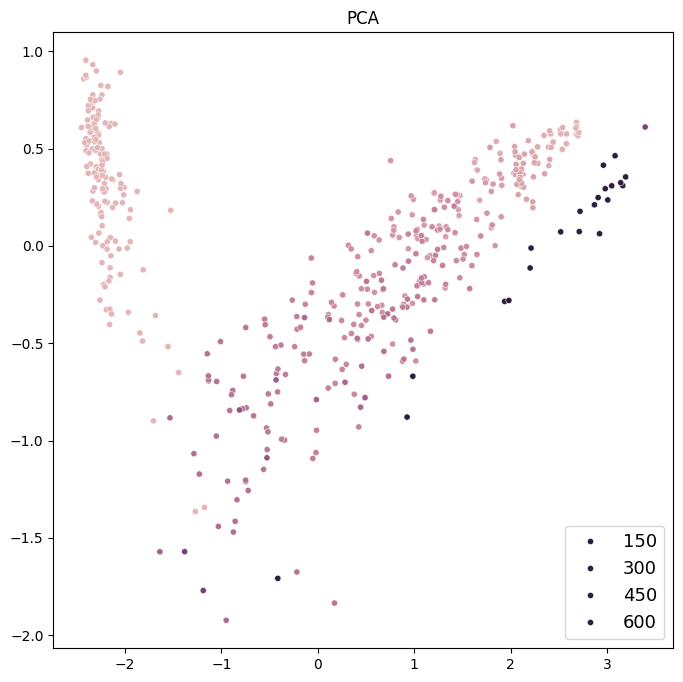

In [16]:
fig = plt.figure(figsize=(8,8))
plt.title('PCA')
sns.scatterplot(x=projected_mean_embeddings[:,0], y=projected_mean_embeddings[:,1], s=20, hue=lens[:], hue_norm=(0,50))
plt.legend(fontsize=13)
#plt.xticks(range(-12,12,2))
#plt.xlim([-10.5,10.5])

#plt.yticks(range(-8,10,2))
#plt.ylim([-6.8,7.5])

plt.show()
#sns.scatterplot(x=X_new_ap[:,0], y=X_new_ap[:,1], s=10, label='amypro')

In [17]:
serr_lens = list(serrano['sequence'].apply(lambda x: len(x)))
serr = ['Serrano158'] * len(serr_lens)
amypro_lens = list(amypro['len'])
amyp = ['AmyPro22'] * len(amypro_lens)
waltz_lens = list(waltz['sequence'].apply(lambda x: len(x)))
waltz = ['WaltzDB-padded'] * len(waltz_lens)
d = {}
d['lens'] = serr_lens + waltz_lens
d['Dataset'] = serr  + waltz
d = pd.DataFrame(d)

(0.0, 35.0)

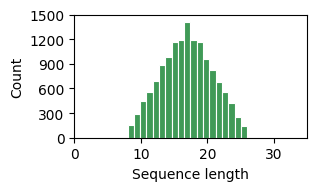

In [18]:
fig = plt.figure(figsize=(3,1.6))
sns.histplot(waltz_lens,bins=19, color=lacroix.colorList('Keylime')[3], edgecolor="white")
plt.xlabel('Sequence length')
plt.yticks(range(0,1800,300))
plt.xlim([0,35])

#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_waltzhist.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_waltzhist.pdf', dpi=600, bbox_inches='tight')

(0.0, 700.0)

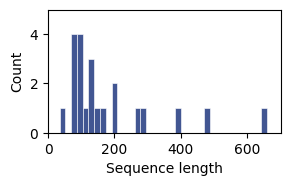

In [19]:
fig = plt.figure(figsize=(3,1.6))
sns.histplot(amypro_lens,bins=36, color=lacroix.colorList('Keylime')[4], edgecolor="white")
plt.xlabel('Sequence length')
plt.ylim([0,5])
plt.xlim([0,700])

#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_amyprohist.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_amyprohist.pdf', dpi=600, bbox_inches='tight')

Text(0.5, 0, 'Sequence length')

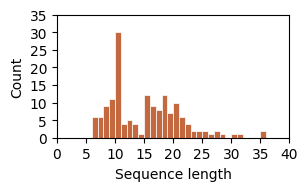

In [20]:
fig = plt.figure(figsize=(3,1.6))
sns.histplot(serr_lens,bins=30, color=lacroix.colorList('Keylime')[0], edgecolor="white")
plt.xticks(range(0,45,5))
plt.yticks(range(0,40,5))
plt.ylim([0,35])
plt.xlim([0,40])
plt.xlabel('Sequence length')

#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_serranohist.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_serranohist.pdf', dpi=600, bbox_inches='tight')

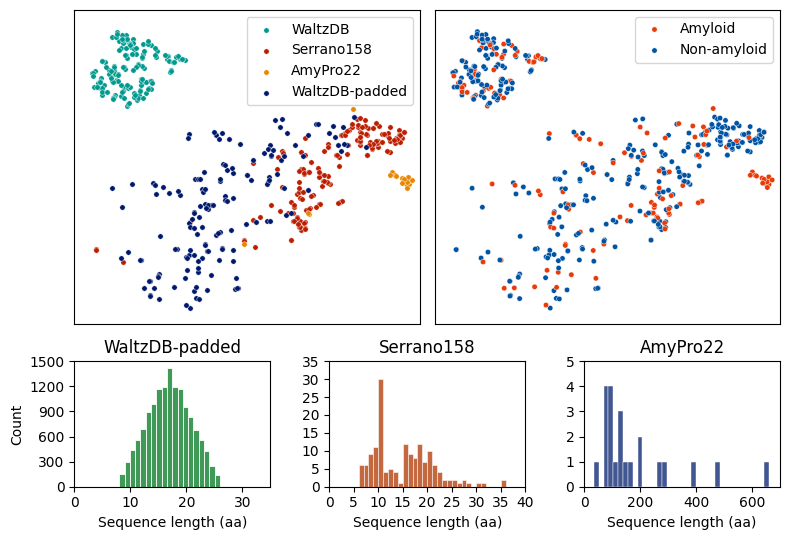

In [88]:
fig = plt.figure(figsize=(8, 5.5))  
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 0.8])  

ax1 = fig.add_subplot(gs[0, 0]) 
sns.scatterplot(x=X_new_all[-750:-600,0], y=X_new_all[-750:-600,1], s=15, label='WaltzDB', c=lacroix.colorList('Apricot')[3], ax=ax1)
sns.scatterplot(x=X_new_all[172:-750,0], y=X_new_all[172:-750,1], s=15, label='Serrano158', c=lacroix.colorList('Apricot')[0],ax=ax1)
sns.scatterplot(x=X_new_all[:22,0], y=X_new_all[:22,1], s=15, label='AmyPro22', c=lacroix.colorList('Apricot')[1],ax=ax1)
sns.scatterplot(x=X_new_all[22:172,0], y=X_new_all[22:172,1], s=15, label='WaltzDB-padded', c=lacroix.colorList('Apricot')[2],ax=ax1)

ax1.legend(fontsize=10, loc='upper right')

ax1.set_ylim([-60,69])
ax1.set_xlim([-64,85])

ax1.set_xticks([])
ax1.set_yticks([])
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)

ax2 = fig.add_subplot(gs[0, 1]) 
sns.scatterplot(x=list(X_new_all[:-600,0]), y=list(X_new_all[:-600,1]), s=15, hue=labels_txt[:-600], palette=[lacroix.colorList('PeachPear')[0],lacroix.colorList('Lime')[4]], ax=ax2)
ax2.legend(fontsize=10, loc='upper right')

ax2.set_ylim([-60,69])
ax2.set_xlim([-64,85])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)


gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1, :], wspace=0.3) 

ax3 = fig.add_subplot(gs_bottom[0, 0]) 
sns.histplot(waltz_lens,bins=19, color=lacroix.colorList('Keylime')[3], ax=ax3, edgecolor="white")
ax3.set_title('WaltzDB-padded')
ax3.set_xlabel('Sequence length (aa)')
ax3.set_yticks(range(0,1800,300))
ax3.set_xlim([0,35])

ax4 = fig.add_subplot(gs_bottom[0, 1])
sns.histplot(serr_lens,bins=30, color=lacroix.colorList('Keylime')[0], ax=ax4, edgecolor="white")
ax4.set_xticks(range(0,45,5))
ax4.set_yticks(range(0,40,5))
ax4.set_ylim([0,35])
ax4.set_xlim([0,40])
ax4.set_ylabel('')
ax4.set_title('Serrano158')
ax4.set_xlabel('Sequence length (aa)')

ax5 = fig.add_subplot(gs_bottom[0, 2]) 
sns.histplot(amypro_lens,bins=36, color=lacroix.colorList('Keylime')[4], ax=ax5, edgecolor="white")
ax5.set_title('AmyPro22')
ax5.set_xlabel('Sequence length (aa)')
ax5.set_ylabel('')
ax5.set_yticks(range(-1,6,1))
ax5.set_ylim([0,5])
ax5.set_xlim([0,700])

plt.tight_layout()
plt.show()

#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_FULL.png', dpi=600, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/fig1_FULL.pdf', dpi=600, bbox_inches='tight')